## The Context
Founded in 2014, [Afterpay](https://www.afterpay.com/index) is a wildly successful Australian fintech startup. 
With a market capitalisation of circa 14 billion USD (At the time of writing), it has rapidly grown to one of Australia's largest companies. Afterpay lets customers pay for products in 4 separate payments and charges stores a margin for this. 

I'm interested in applying Bayesian analysis to understand more about Afterpay, based on the information it has provided to the market, plus a little common sense. 

Why Bayesian analysis? After all, we could use least means squares to fit a curve. 

In short, Bayesian analysis will give us a better idea of how wrong we could be. 

:::{.callout-important}

Obviously, I need a disclaimer. If you use anything I say as the basis for any decision, financial or otherwise, you are an idiot.

:::


Now, with that out of the way, let's get started.


## Our goal

While reading through Afterpay's releases to the markets, I came across this chart, which appears on page 3 of [this](https://www.afterpaytouch.com/images/APT_ASX-Announcement_Q2-FY18_16-Jan-Final-2.pdf) release.


![Image of Afterpay customer growth](../images/2020-08-13-Modelling-Afterpays-Customer-Growth/CustomerGrowth.png)

Given this graph, you might try to answer some questions:

1. What is the "saturation level" of *Afterpay* in the Australian market?
2. How long will it take to get there?
3. When will it be growing the fastest?
4. How confident can you be in your answer?

Bayesian analysis can help us answer these questions.


## The Model

First off, let's load the libraries we will later need.

In [1]:
%matplotlib inline
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

from io import StringIO
import pandas as pd

import math

plt.rcParams["figure.figsize"] = (10,10)
from warnings import filterwarnings
filterwarnings('ignore')

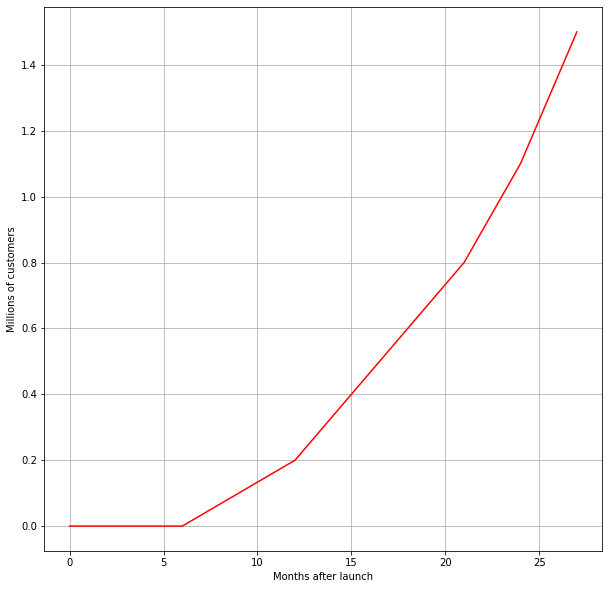

In [2]:
csv_data = StringIO('''millions_customers,date,month_count
            0.0,30-sep-2015,0 
            0.0,31-dec-2015,3 
            0.0,31-mar-2016,6 
            0.1,30-jun-2016,9 
            0.2,30-sep-2016,12
            0.4,31-dec-2016,15
            0.6,31-mar-2017,18
            0.8,30-jun-2017,21
            1.1,30-sep-2017,24
            1.5,31-dec-2017,27''')


df = pd.read_csv(csv_data, sep=",")
plt.plot(df.month_count,df.millions_customers,color='r')
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.grid()
plt.show()

We can see a rapid, accelerating growth in the number of customers over time. 

One model we could use is the [sigmoidal model](https://www.sciencedirect.com/science/article/pii/S1877705811001597/pdf?md5=a6adf115754239aeb12922ec06a20a9e&pid=1-s2.0-S1877705811001597-main.pdf). Also known as "The *S* shaped curve", it's a model where growth starts slow, accelerates, before slowing again. It's often used in technology adoption or the introduction of a new product.

$$\frac{1}{1+e^{-x}}$$


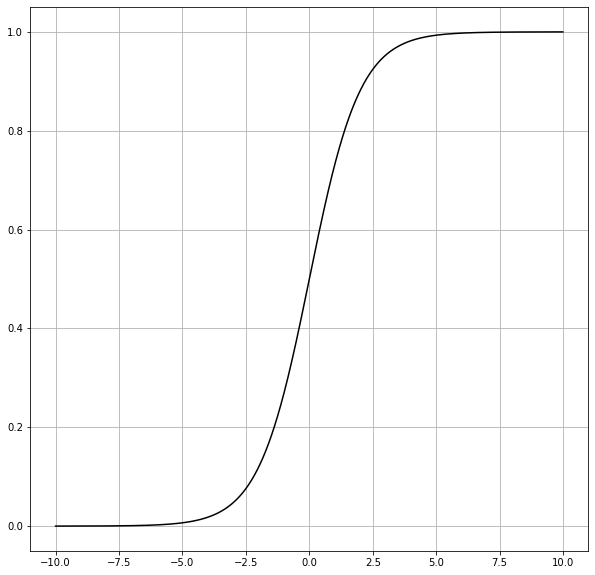

In [3]:
x = np.arange(-10,10,0.01)
y = 1/(1+math.e**-x)
plt.plot(x,y,color='k')
plt.grid()
plt.show()

We can modify the model to modify the scale (*L*), how fast it grows (*k*), or when the fastest growth occurs (*x0*).

$$\frac{L}{1+e^{-k(x-x_0)}}$$

We can fit this model to the data provided by Afterpay using PyMC3.

We can also utilise priors to inject things we might know or suspect. 

For example, while I am open-minded about what proportion of Australians may choose to become customers of Afterpay, I limit the model to a maximum of 25M customers (population of Australia).  I'm using a *Uniform* distribution to emphasise that I have no firm belief about the final number of customers. 

I'm also using uniform priors for $k$, the growth rate, and $x_0$, the time in months at which growth is the fastest.

In general, this isn't great practice because I explicitly exclude the possibility that there could be more than 25M customers, and no amount of data will be able to change my mind.

To quote Cromwell : *I beseech you, in the bowels of Christ, think it possible that you may be mistaken.*

Let's compose this as a Bayesian Regression problem.

In [4]:
with pm.Model() as model:
    millions_customers = df.millions_customers.values
    x = df.month_count.values.astype(np.float64)
    L =  pm.Uniform('L', lower = 0, upper = 25) 
    k =  pm.Uniform('k', lower=0, upper=1) 
    x0 = pm.Uniform('x0', lower=0, upper=100)
    
    customers_predicted = L/(1+math.e**(-k*(x-x0)))
    customers = pm.Normal('customers', mu = customers_predicted, sigma = 0.1, observed = millions_customers)
    

In [5]:
with model:
    trace = pm.sample(draws=10_000,tune=5_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [x0, k, L]
Sampling 2 chains, 0 divergences: 100%|██████████| 30000/30000 [01:15<00:00, 397.13draws/s]
The number of effective samples is smaller than 25% for some parameters.


## The Results
From the following plots, we can notice several things. Firstly, and most importantly, our model converged well. Secondly, according to our model, we expect the number of customers to saturate below 5m people. Still, we might have a lot more customers, even 25m.

Finally, there is a lot of uncertainty around the timing of the peak of the growth. This ranges from approximately two to four years after the introduction of *Afterpay*.

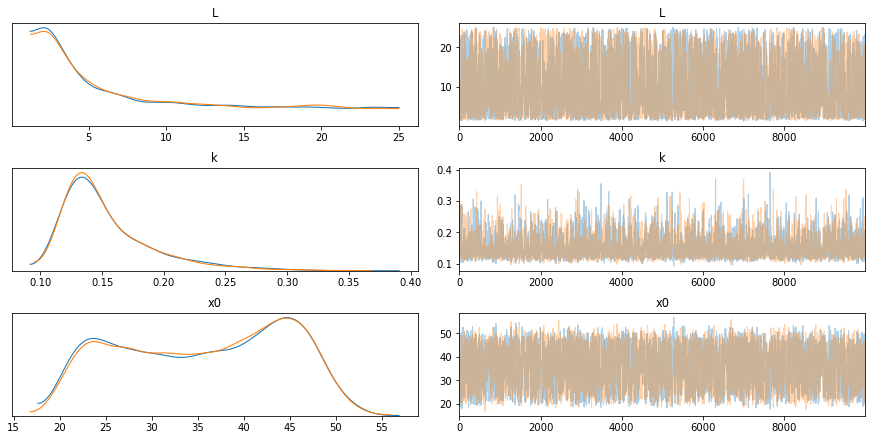

In [6]:
pm.traceplot(trace);

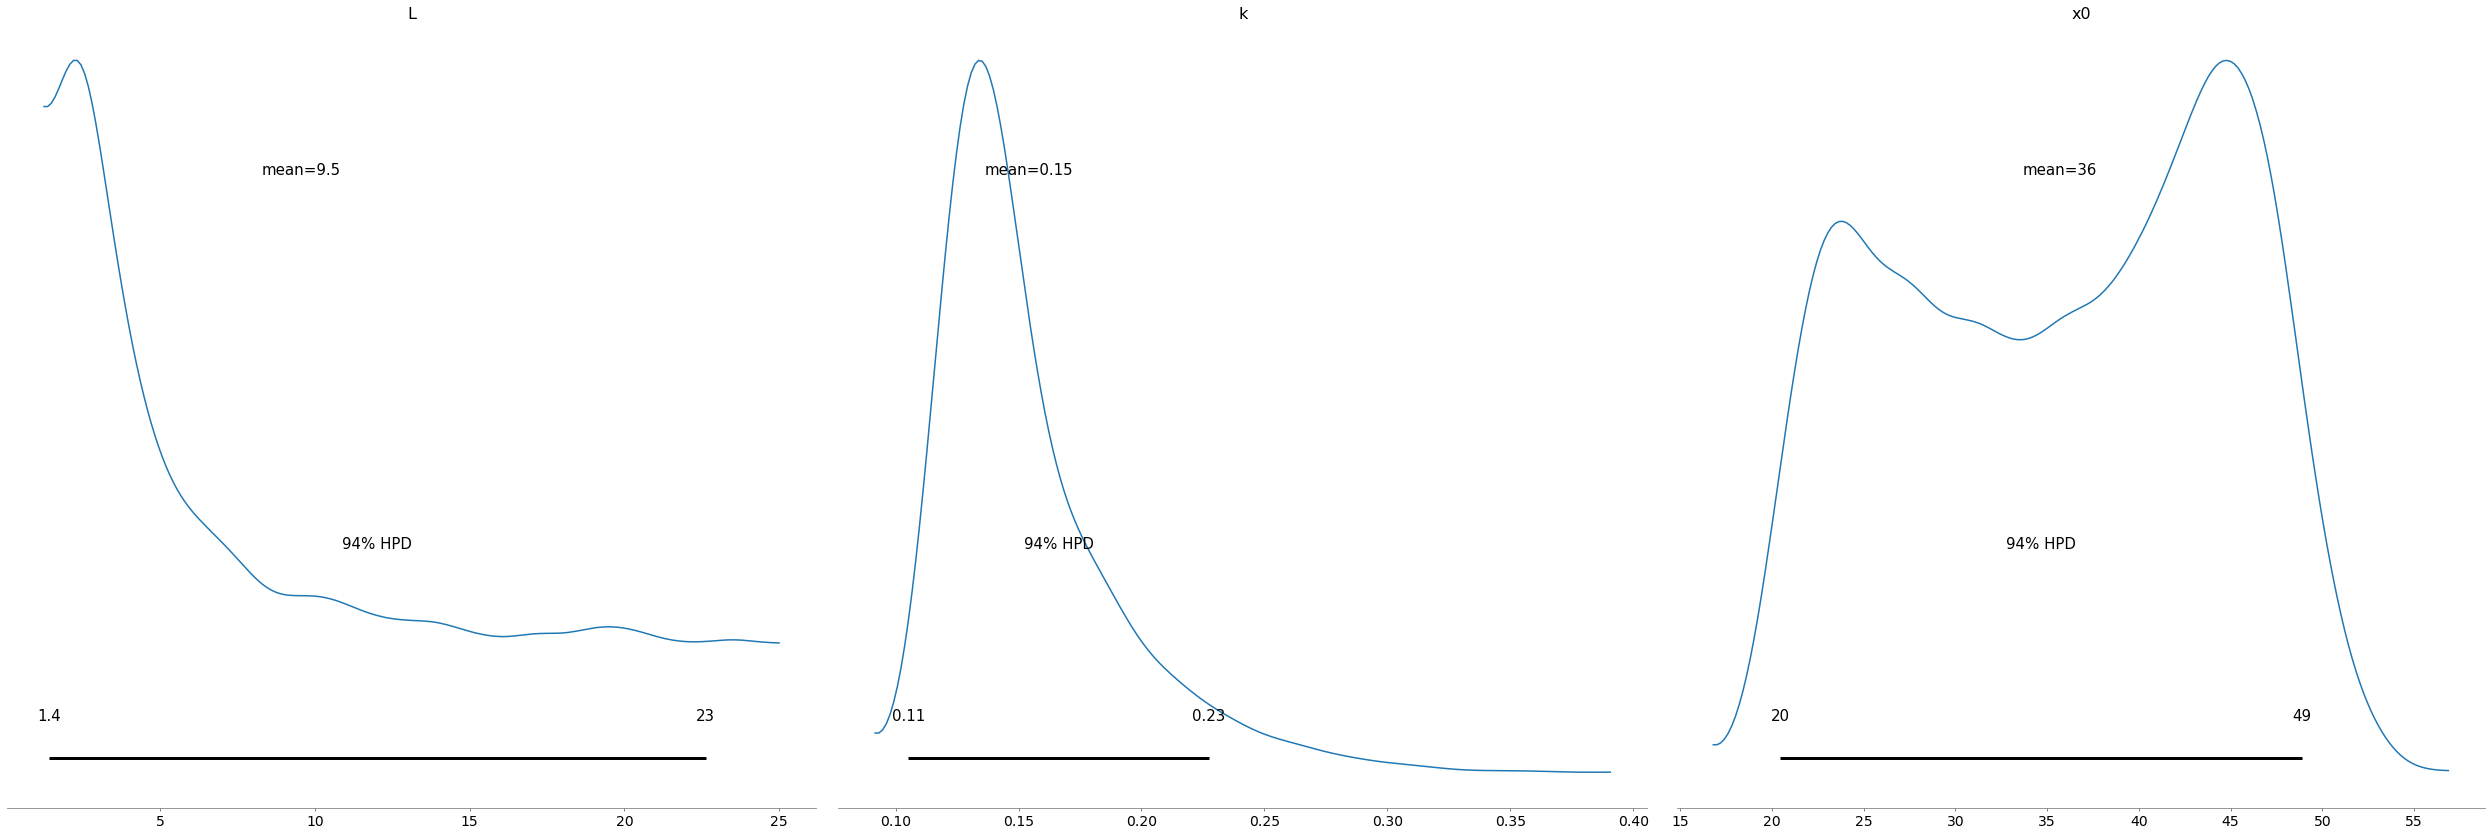

In [7]:
pm.plot_posterior(trace);

In [8]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
L,9.545,7.107,1.393,22.628,0.144,0.102,2441.0,2441.0,2226.0,3639.0,1.0
k,0.154,0.037,0.105,0.227,0.001,0.001,2431.0,2359.0,2876.0,2962.0,1.0
x0,35.685,8.967,20.444,48.898,0.185,0.131,2339.0,2339.0,2363.0,3996.0,1.0


## Posterior Predictive Checks
Let's see if our model makes sense. By drawing samples from our model, we can further investigate the potential growth rates of Afterpay. 

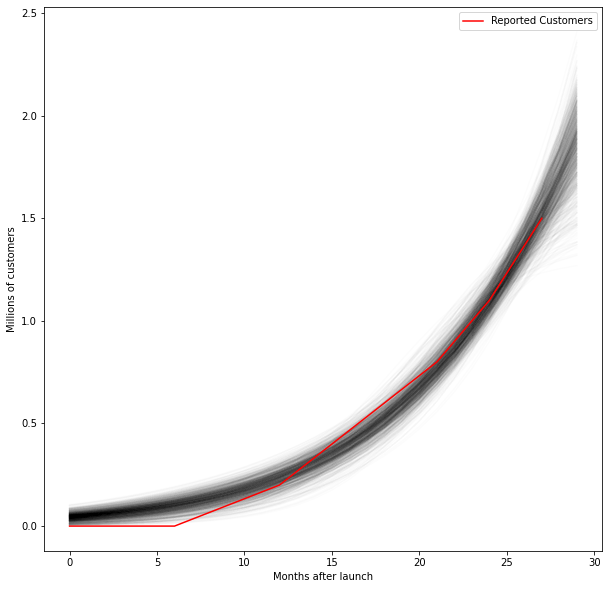

In [9]:
for i in range(0,1_000):
    x = np.arange(0,30)
    plt.plot(x,trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i]))),color='k',alpha=0.01)
plt.plot(df.month_count,df.millions_customers,color='r',label='Reported Customers')

plt.legend()
plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.show()

Now let's start forecasting the future. We can compare what we modelled to the actual customer numbers (3.1M) [reported](https://www.afterpaytouch.com/images/27022019-H1-FY20-Results-Presentation.pdf) by Afterpay 54 months after they launched. 


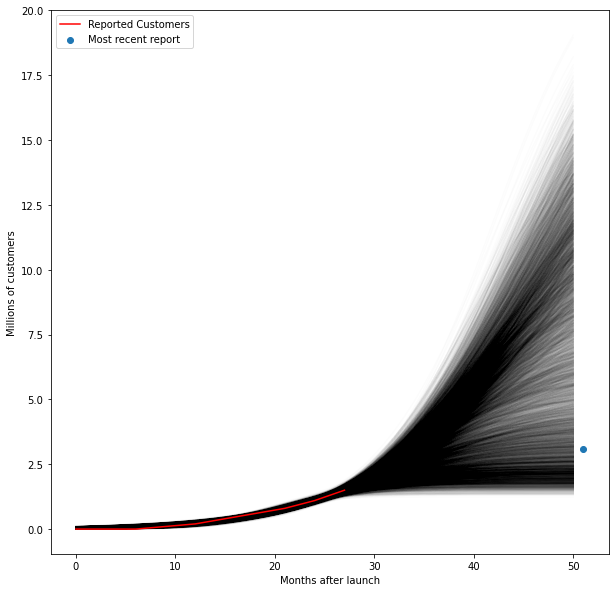

In [10]:
for i in range(0,10_000):
    x = np.arange(0,51)
    plt.plot(x,trace['L'][i]/(1+math.e**(-trace['k'][i]*(x-trace['x0'][i]))),color='k',alpha=0.01)
plt.plot(df.month_count,df.millions_customers,color='r',label='Reported Customers')


plt.scatter(51,3.1,label='Most recent report')
plt.legend()

plt.ylabel('Millions of customers')
plt.xlabel('Months after launch')
plt.show()

We can also generate a histogram and compare the predictions of our model with the actual true number of 3.1M.

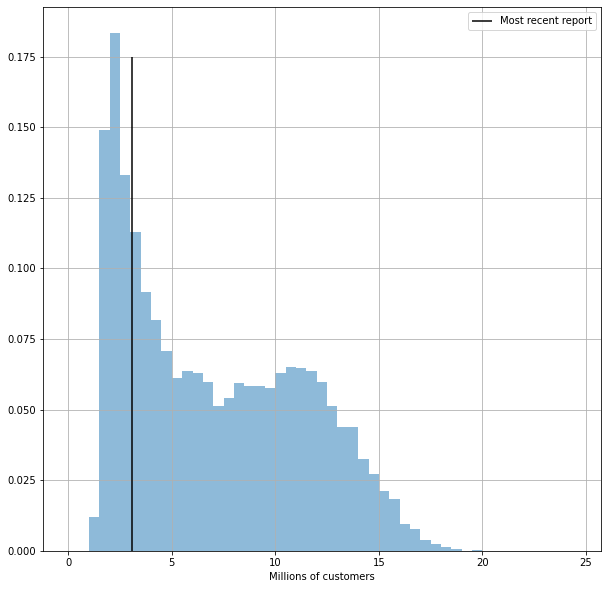

In [11]:
x = 51*np.ones(20000)
y = trace['L']/(1+math.e**(-trace['k']*(x-trace['x0'])))                              
plt.hist(y,bins=np.arange(0,25,0.5),alpha=0.5,density=True)
plt.vlines(3.1,0,0.175,label='Most recent report')
        
plt.xlabel('Millions of customers')
plt.legend()
plt.grid()
plt.show()

## Conclusion
In conclusion, Bayesian analysis is a powerful tool because it allows us to understand how confident we are in our predictions. It's also powerful because we can feed in the information we might already believe. If you are 80% sure that at most 20% of the Australian population will use Afterpay, you can feed this in as a prior. 

This type of analysis is also essential, as the [AFR](https://www.afr.com/markets/equity-markets/afterpay-s-fate-tied-to-us-growth-20200827-p55pwu) makes clear, *Afterpay's* fate is intricately linked to their customer growth.


While this is a relatively *rough and ready* model, It's interesting. We can see considerable uncertainty in the final number of customers we expect Afterpay to have.

We also must remember that we picked an inappropriate model to fit, which might not fit reality appropriately.